# First Practical work

* Name Student 1: Matteo Oliver Bekink
* NIA Student 1: 100575997
* Name Student 2: Pau Tarragona Juanes
* NIA Student 2: 100575996
* Name Student 3:
* NIA Student 3:
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data






## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [3]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [4]:
import  numpy  as  np
from sys import getsizeof
import time
from os.path import join

In [5]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [6]:
import nibabel as nib

In [7]:
# import your_library here
from multiprocessing.sharedctypes import Value, Array, RawArray
from multiprocessing import Process, Lock
import multiprocessing as mp
import ctypes
import scipy as sp
from scipy import ndimage

# Three-dimensional filtering

The objective of the practice is to implement a three-dimensional filtering of information (usually a 3-dimensional image coming from, for example, medical images) to which a preprocessing must be performed for further analysis.

Due to technical limitations, we will assume that the filtering function is a cube of 3x3 voxels (or three-dimensional pixel) and the image will have a maximum size of 1Gbyte (1024x1024x1024), although it will not necessarily be cubic.

## How to filter a voxel?
To filter a voxel we select the coordinates of the voxel we want to filter and the surrounding neighbors in the 3 dimensions (for a 3x3 filter the coefficient corresponding to the voxel to be filtered corresponds to the positions (1,1,1) of the filter mask).
The n selected neighbors are multiplied by the corresponding coefficients in the filter mask, around the selected voxel, and the products are summed, as in the case of 2-dimensional filters.

The result of this sum is the value assigned to the selected position of the resulting voxel.

## Cases at the edges
To calculate the filtered voxel at a position corresponding to one of the edges of the image, we replicate that layer, so that the data of the missing layer is equal to that of the layer to be filtered.
In the case of edges or corners, the value of the corresponding corner is replicated.

## Clapping
The resulting data will be an floating point 32bits data.

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out. 

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [8]:
# 
# from google.colab import drive
# drive.mount("/content/drive")

In [9]:
# !ls /content/drive/My\ Drive/images

## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [10]:
MYDRIVE="./imgs"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [11]:
#IMAGE=join(MYDRIVE,HERE YOU HAVE TO WRITE THE IMAGE TO LOAD)

In [12]:
IMAGE=join(MYDRIVE,'someones_epi.nii.gz')

In [13]:
print("Image to load: {0}".format(IMAGE))

Image to load: ./imgs\someones_epi.nii.gz


Loads an image in a numpy variable, and show.

In [14]:
epi_img = nib.load(IMAGE)
epi_img_data = epi_img.get_fdata().astype(np.float32)
epi_img_data.shape

(53, 61, 33)

In [15]:
epi_img_data_final = epi_img_data.T

In [16]:
epi_img_data_final.shape

(33, 61, 53)

In [17]:
epi_img_data.dtype

dtype('float32')

Text(0.5, 0.98, 'Center slices for EPI image')

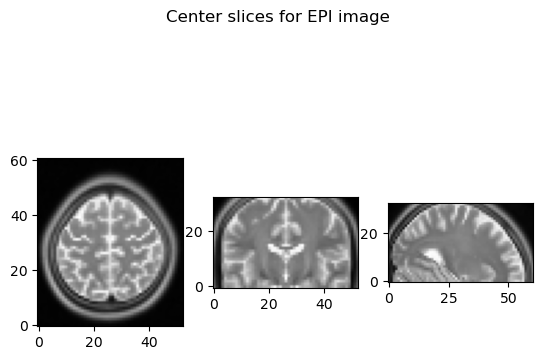

In [18]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [19]:
#This is an identity filter: the resulting
filter1=np.zeros((3,3,3),dtype=np.float32)
filter1[1,1,1] =1.0

In [20]:
#This is an edge detector filter in xy axis filter: the resulting
filter2=np.zeros((3,3,3),dtype=np.float32)
filter2[0,0,1] = -0.25
filter2[2,0,1] = -0.25
filter2[0,2,1] = 0.25
filter2[2,2,1] = 0.25

In [21]:
#This is an edge detector filter in xz axis: the resulting
filter3=np.zeros((3,3,3),dtype=np.float32)
filter3[0,1,0] = -0.25
filter3[2,1,0] = -0.25
filter3[0,1,2] = 0.25
filter3[2,1,2] = 0.25

# YOUR CODE

## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [32]:
image_shape=epi_img_data_final.shape
print(image_shape)

(33, 61, 53)


Allocates the target image memory.

In [33]:
data_size = image_shape[0]*image_shape[1]*image_shape[2]
print(data_size)

# Use float32 for image data and create a NumPy view with the right shape
filtered_image_shm = Array(ctypes.c_float, data_size, lock=True)
filtered_image = np.frombuffer(filtered_image_shm.get_obj(), dtype=np.float32).reshape(image_shape)

106689


### Extra Function we might need

In [24]:
def to_numpyarray(mp_arr):
    return np.frombuffer(mp_arr.get_obj(), dtype=np.float32)

def init_sharedarray(shared_array,img_shape):
    global shared_space
    global shared_matrix

    shared_space = shared_array
    shared_matrix = to_numpyarray(shared_space).reshape(img_shape)

def parallel_copy_image_rows(image,row):

        global shared_space
        global shared_matrix
        
        image = image
        # with this instruction we lock the shared memory space, avoiding other parallel processes tries to write on it
        with shared_space.get_lock():
            #while we are in this code block no ones, except this execution thread, can write in the shared memory
            shared_matrix[row,:,:]=image[row,:,:]
        return

In [25]:
def same_padding(pad,arr):
    (rows,cols,depths)=arr.shape

    new_rows=rows+2*pad
    new_cols=cols+2*pad
    new_depths=depths+2*pad

    padded = np.zeros((new_rows,new_cols,new_depths), dtype=arr.dtype)
    
    padded[pad:pad+rows, pad:pad+cols, pad:pad+depths] = arr

    for i in range(pad):
        # Pad along rows
        padded[i, pad:pad+cols, pad:pad+depths] = arr[0, :, :]
        padded[new_rows - i - 1, pad:pad+cols, pad:pad+depths] = arr[rows - 1, :, :]

        # Pad along columns
        padded[:, i, pad:pad+depths] = padded[:, pad, pad:pad+depths]
        padded[:, new_cols - i - 1, pad:pad+depths] = padded[:, new_cols - pad - 1, pad:pad+depths]

        # Pad along depths
        padded[:, :, i] = padded[:, :, pad]
        padded[:, :, new_depths - i - 1] = padded[:, :, new_depths - pad - 1]

    return padded

## CHECK PADDED SIZE

In [26]:
k = filter1.shape[0] // 2
padded = same_padding(k, epi_img_data_final)
print(padded.shape)
print(padded[:4,:4,0])

(35, 63, 55)
[[10.755072 10.755072 10.755072 10.755072]
 [10.755072 10.755072 10.755072 10.755072]
 [11.131637 11.131637 11.131637 11.131637]
 [10.755072 10.755072 10.378507 10.755072]]


We want to iterate over the rows of the original image, ie we want to start at `row=[1,34]` and `col=[1,62]` and `depth=[1,54]`

In [27]:
#Include filtered_image=None if TESTING
def convolve(row, image, padded, kernel):# filtered_image=None):
    rows, cols, depths = image.shape  # Original image shape, NOT padded
    k = kernel.shape[0] // 2
    
    # Iterate over all cells in the original image
    for c in range(cols):
        for d in range(depths):
            # Map to padded image coordinates (add offset k)
            padded_row = row + k
            padded_c = c + k
            padded_d = d + k
            
            # Extract ROI from padded image
            # When row = 0, then padded[0:2k+1, ...] if k = 1 then padded[0:3, ...]
            roi = padded[padded_row - k:padded_row + k + 1, 
                         padded_c - k:padded_c + k + 1, 
                         padded_d - k:padded_d + k + 1]
            
            # Store result in original image coordinates
            filtered_image[row, c, d] = float(np.sum(roi * kernel))

## TEST CONVOLVE
We will test this by taking a small `3x3x3` cube of the image and convolving it with both kernels and running the numbers by hand. We expect the convolution to run over all the indices (in the image) of `1,1,1` up until `3,3,3`.
We will perform two tests, one to compare the filtered image with the original image and the other with a scipy solution
* For `filter_1` we expect the test to be :  `True,True`
* For `filter_2` we expect the test to be :  `False,True`
* For `filter_2` we expect the test to be :  `False,True`

In [28]:
image = epi_img_data_final[:3,:3,:3]
image_shape=image.shape
print(image_shape)
 
filter = filter1

k = filter.shape[0] // 2
padded = same_padding(k, image)
# We expect the cube to become 5x5x5 after padding
print(padded.shape)

filtered_image = np.zeros(image.shape, dtype=image.dtype)

for row in range(image.shape[0]):
    convolve(row, image, padded, filter, filtered_image=filtered_image)

print(np.allclose(filtered_image, image))

actual_output = ndimage.correlate(image, filter, mode='nearest')
print(np.allclose(filtered_image, actual_output,atol=1e-4))



(3, 3, 3)
(5, 5, 5)


TypeError: convolve() got an unexpected keyword argument 'filtered_image'

In [30]:
def run_parrallel(sh_data, image, filter, NUMCORES=20):
    image_shape = image.shape
    result_matrix = to_numpyarray(sh_data).reshape(image_shape)
    
    k = filter.shape[0]//2
    padded = same_padding(k, image)
    padded_rows = range(padded.shape[0])
    rows = range(image.shape[0])

    # Single pool for all operations
    with mp.Pool(processes=NUMCORES, initializer=init_sharedarray, initargs=[sh_data,image_shape]) as p:
        # Create argument pairs for each row
        copy_args = [(padded, row) for row in padded_rows]
        p.starmap(parallel_copy_image_rows, copy_args)
        
        # Create argument tuples for convolution
        conv_args = [(row, image, padded, filter) for row in rows]
        p.starmap(convolve, conv_args)

    return result_matrix 

In [ ]:
filter = filter1
run_parrallel(filtered_image_shm,epi_img_data_final,filter)
print(np.allclose(filtered_image, epi_img_data_final,atol=1e-4))

# Show results


Text(0.5, 0.98, 'Center slices for EPI image')

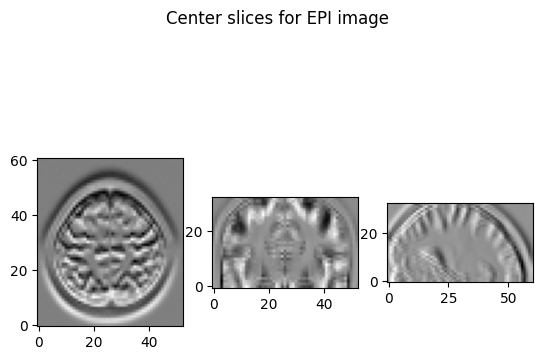

In [ ]:
slice_0 = filtered_image[26, :, :]
slice_1 = filtered_image[:, 30, :]
slice_2 = filtered_image[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

Text(0.5, 0.98, 'Center slices for EPI image (test)')

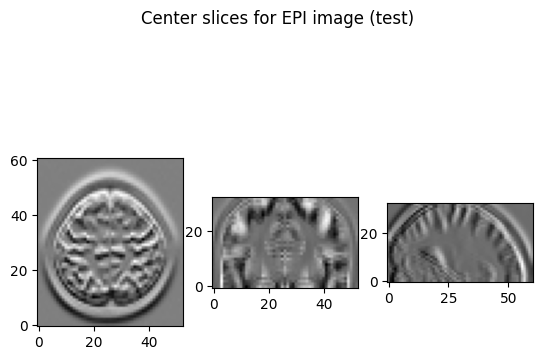

In [ ]:
slicetest_0 = test_convolved[26, :, :]
slicetest_1 = test_convolved[:, 30, :]
slicetest_2 = test_convolved[:, :, 16]

show_slices([slicetest_0, slicetest_1, slicetest_2])
plt.suptitle("Center slices for EPI image (test)")

In [ ]:
# print("Best execution time: {}".format(statistics.best))
# print("Worst execution time: {}".format(statistics.worst))
# print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

# CONCLUSIONS